## 1.Importing Libraries

In [1]:
import os,json,cv2,numpy as np,matplotlib.pyplot as plt 

import torch 
from torch.utils.data import Dataset,DataLoader 

import torchvision 
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F 

import albumentations as A

/home/anto/anaconda3/envs/cattle/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import transforms,utils,engine,train 
from utils import collate_fn 
from engine import train_one_epoch,evaluate

## 2.Augmentations

In [3]:
def train_transforms():
    return A.Compose([
        A.Sequential([
            A.RandomRotate90(p=1),
            A.HorizontalFlip(p=0.5), 
            A.RandomBrightnessContrast(p=0.3)
        ],p=1)
    ],
    keypoint_params = A.KeypointParams(format='xy'),
    bbox_params = A.BboxParams(format='pascal_voc',label_fields=['bboxes_labels'])
    )

## 3.Dataset Class

In [130]:
class ClassDataset(Dataset):
    def __init__(self,root,transform=None,demo=False):
        self.root = root 
        self.transform = transform 
        self.demo = demo 
        self.imgs_files = sorted(os.listdir(os.path.join(root,"images"))) 
        self.annotations_files = sorted(os.listdir(os.path.join(root,"annotations"))) 

    def __len__(self):
            return len(self.imgs_files)
        
    def unflatten(self,keypoints_original,keypoints_original_flattened): 
        keypoints_transformed_unflattened=[] 
        
        
    def __getitem__(self,idx):
        img_path = os.path.join(self.root,"images",self.imgs_files[idx])
        annotations_path = os.path.join(self.root,"annotations",self.annotations_files[idx]) 
        
        img_original = cv2.imread(img_path) 
        img_original = cv2.cvtColor(img_original,cv2.COLOR_BGR2RGB) 
        
        with open(annotations_path) as f:
            data = json.load(f) 
            bboxes_original = data['bboxes']
            keypoints_original = data['keypoints'] 
            print(keypoints_original)
            bboxes_labels_original = ['mouth' for _ in bboxes_original] 

        if self.transform:
            temp=[el1 for kp in keypoints_original for el in kp for el1 in el if len(el)] 
            keypoints_original_flattened=[None]*len(temp)
            print("flattened keypoints",keypoints_original_flattened)
            keypoints_original_flattened = [el1 for kp in keypoints_original for el in kp for el1 in el[:2] if len(el)] 
            print("flattened keypoints",keypoints_original_flattened)
            transformed = self.transform(image=img_original,
                                         bboxes=bboxes_original,
                                         bboxes_labels=bboxes_labels_original,
                                         keypoints=keypoints_original[0])
            img = transformed['image']
            bboxes = transformed['bboxes']
    
            print(transformed['keypoints'])
            #keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']),(-1,2,2)).tolist() 
            keypoints_transformed_unflattened = [[list(t) for t in transformed['keypoints']]]
            keypoints=[] 
            for o_idx,obj in enumerate(keypoints_transformed_unflattened):
                obj_keypoints = [] 
                for k_idx,kp in enumerate(obj):
                    obj_keypoints.append(kp[:2]+[keypoints_original[o_idx][k_idx][2]])
                keypoints.append(obj_keypoints) 
        else:
            img,bboxes,keypoints = img_original,bboxes_original,keypoints_original 

        bboxes = torch.as_tensor(bboxes,dtype=torch.float32) 
        target = {} 
        target["boxes"] = bboxes 
        target["labels"] = torch.as_tensor([1 for _ in bboxes],dtype=torch.int64)
        target["image_id"] = torch.tensor([idx])
        target["area"] = (bboxes[:,3]-bboxes[:,1])*(bboxes[:,2]-bboxes[:,0])
        target["iscrowd"] = torch.zeros(len(bboxes),dtype=torch.int64)
        target["keypoints"] = torch.as_tensor(keypoints,dtype=torch.float32) 
        img = F.to_tensor(img) 

        bboxes_original =torch.as_tensor(bboxes_original,dtype=torch.float32) 
        target_original = {} 
        target_original["boxes"] = bboxes_original 
        target_original["labels"] = torch.as_tensor([1 for _ in bboxes_original],dtype=torch.int64)
        target_original["image_id"] = torch.tensor([idx])
        target_original["area"] = (bboxes_original[:,3]-bboxes_original[:,1])*(bboxes_original[:,2]-bboxes[:,0])
        target_original["iscrowd"] = torch.zeros(len(bboxes_original),dtype=torch.int64)
        target_original["keypoints"] = torch.as_tensor(keypoints_original,dtype=torch.float32) 
        img_original = F.to_tensor(img_original) 

        if self.demo:
            return img,target,img_original,target_original 
        else:
            return img,target 
        
        


## 4.Visualize example

In [90]:
KEYPOINTS_FOLDER_TRAIN ='./train'

In [131]:
dataset = ClassDataset(KEYPOINTS_FOLDER_TRAIN,transform=train_transforms(),demo=True)

In [114]:
#dataset = ClassDataset(KEYPOINTS_FOLDER_TRAIN,demo=True)

In [163]:
data_loader = DataLoader(dataset,batch_size=1,shuffle=True,collate_fn=collate_fn) 
    
iterator = iter(data_loader) 
batch = next(iterator)
print("Original")
print(batch[3])

print("Transformed")
print(batch[1])

[[[124, 245, 1], [122, 231, 1]]]
flattened keypoints [None, None, None, None, None, None]
flattened keypoints [124, 245, 122, 231]
[(245, 124, 1), (231, 122, 1)]
Original
({'boxes': tensor([[110., 222., 134., 250.]]), 'labels': tensor([1]), 'image_id': tensor([66]), 'area': tensor([-2464.]), 'iscrowd': tensor([0]), 'keypoints': tensor([[[124., 245.,   1.],
         [122., 231.,   1.]]])},)
Transformed
({'boxes': tensor([[222., 110., 250., 134.]]), 'labels': tensor([1]), 'image_id': tensor([66]), 'area': tensor([672.]), 'iscrowd': tensor([0]), 'keypoints': tensor([[[245., 124.,   1.],
         [231., 122.,   1.]]])},)


### 4.1

In [158]:
keypoints_classes_ids2names = {0: 'lower', 1: 'upper'}

In [ ]:
def visualize(image, bboxes, keypoints, image_original=None, bboxes_original=None, keypoints_original=None):
    fontsize = 18

    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)
    
    for kps in keypoints:
        for idx, kp in enumerate(kps):
            image = cv2.circle(image.copy(), tuple(kp), 5, (255,0,0), 10)
            image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(40,40))
        plt.imshow(image)

    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)
        
        for kps in keypoints_original:
            for idx, kp in enumerate(kps):
                image_original = cv2.circle(image_original, tuple(kp), 5, (255,0,0), 10)
                image_original = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)

In [166]:
image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints = []
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp[:2] for kp in kps])

image_original = (batch[2][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints_original = []
for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints_original.append([kp[:2] for kp in kps])

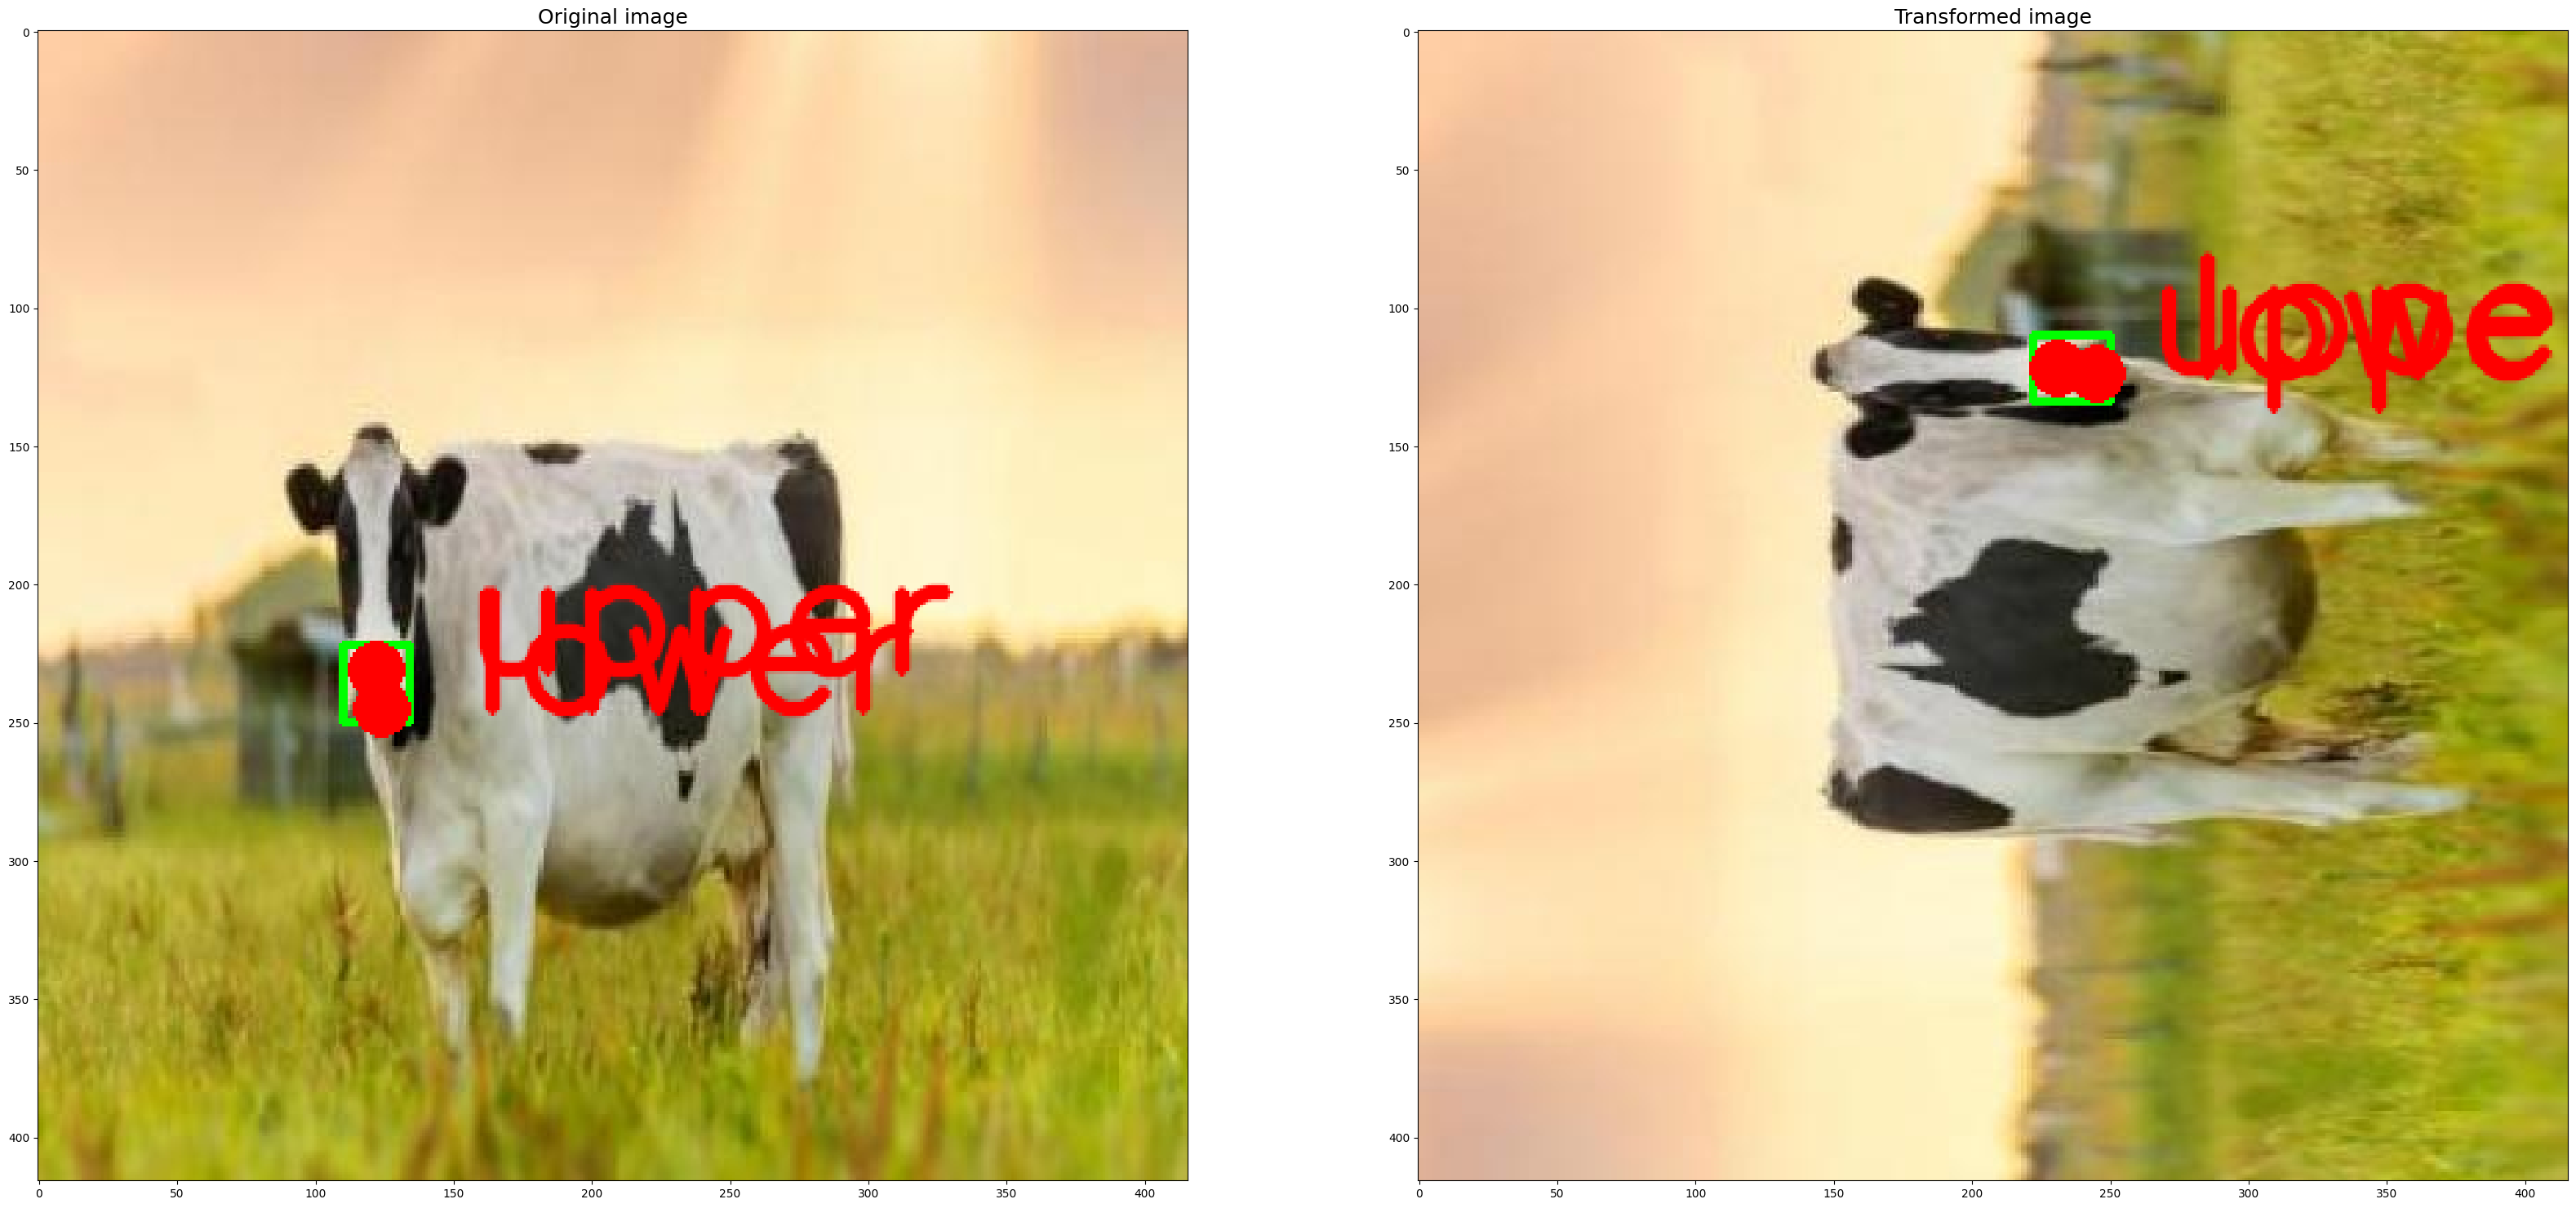

In [167]:
visualize(image, bboxes, keypoints, image_original, bboxes_original, keypoints_original)

## 5.Training

In [168]:
def get_model(num_keypoints,weights_path=None): 
    
    anchor_generator = AnchorGenerator(sizes=(32,64,128,256,512),aspect_ratios=(0.25,0.5,0.75,1.0,2.0,3.0,4.0))
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                                  pretrained_backbone=True,
                                                                  num_keypoints=num_keypoints,
                                                                  num_classes=2,
                                                                  rpn_anchor_generator=anchor_generator)
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)
    return model

In [172]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

KEYPOINTS_FOLDERS_TRAIN ='./train'
KEYPOINTS_FOLDERS_VALID = './valid' 
KEYPOINTS_FOLDERS_TEST = './test'

data_loader_train = ClassDataset(KEYPOINTS_FOLDERS_TRAIN, transform = train_transforms(), demo=False) 
data_loader_test = ClassDataset(KEYPOINTS_FOLDERS_TEST,demo=False) 
data_loader_valid = ClassDataset(KEYPOINTS_FOLDERS_VALID,demo=False)